# 1.) Import an asset price from Yahoo Finance

In [ ]:
!pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.2/59.2 KB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 18.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.4/129.4 KB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 KB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.2/111.2 KB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.2/112.2 KB 7.7 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.25.1
    Uninstalling requests-2.25.1:
      Successfully uninstalled requests-2.25.1
  Attempting uninstall: html5lib
    Found existing installation: html5lib 1.0.1
    Uninstalling html5lib-1.0.1:
      Successfully uninstalled html5lib-1.0.1
  Attempting uninstall: beautifulsoup4
    Found existing installation: beautifulsoup4 4.6.3
   

In [ ]:
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout

In [ ]:
#Pick your ticker and time period
stock_data = yf.download("MSFT", start="1990-01-01", end="2022-02-21")

# Preprocess data
scaled_data = np.array(stock_data["Close"].pct_change().dropna()).reshape(-1,1)

# Split data into training and test sets
training_data_len = int(len(scaled_data) * 0.8)
train_data = scaled_data[0:training_data_len, :]

[*********************100%***********************]  1 of 1 completed


# 2.) Create your x_train/y_train data so that your RNN uses percentage change data to make a binary forecast where the stock moves up or down the next day
# Build an RNN Architecture accordingly

In [ ]:
x_train = []
y_train = []

#Pick your input size and edit to make binary forecast
input_size = 5
for i in range(input_size, len(train_data)):
    x_train.append(train_data[i-input_size:i, 0])
    y_train.append(train_data[i, 0])

x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

#Build Your RNN Architecture
model = Sequential()
model.add(LSTM(x_train.shape[1], return_sequences = True, input_shape = (x_train.shape[1], 1)))
model.compile(optimizer = 'adam', loss='mean_squared_error')
model.fit(x_train, y_train, batch_size = 1, epochs = 3)

Epoch 1/3
6472/6472 [==============================] - 40s 5ms/step - loss: 4.3570e-04
Epoch 2/3
6472/6472 [==============================] - 23s 3ms/step - loss: 4.3314e-04
Epoch 3/3
6472/6472 [==============================] - 24s 4ms/step - loss: 4.3263e-04


# 3.) Test your model and compare insample Accurracy, insample random walk assumption Accuracy, Out of sample Accuracy and out of sample random walk assumption Accuracy using a bar chart

In [ ]:
test_data = scaled_data[training_data_len - input_size:, :]

x_test = []
y_test = np.array(stock_data[["Close"]].pct_change().dropna())[training_data_len:, :]
for i in range(input_size, len(test_data)):
  x_test.append(test_data[i-input_size:i, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

predictions = model.predict(x_test)

51/51 [==============================] - 1s 2ms/step


In [ ]:
# IN Random walk model
In_sample_act = y_train[1:]
In_sample_pred = y_train[:-1]
# OOS Random walk model
Out_sample_act = y_test[1:]
Out_sample_pred = y_test[:-1]

In [ ]:
In_sample_pred = np.array([1 if x > 0 else 0 for x in In_sample_pred])
Out_sample_pred = np.array([1 if x > 0 else 0 for x in Out_sample_pred])
In_sample_act = np.array([1 if x > 0 else 0 for x in In_sample_act])
Out_sample_act = np.array([1 if x > 0 else 0 for x in Out_sample_act])

In [ ]:
from sklearn.metrics import accuracy_score
In_accuracy = accuracy_score(In_sample_act,In_sample_pred)
Out_accuracy = accuracy_score(Out_sample_act,Out_sample_pred)

<BarContainer object of 2 artists>

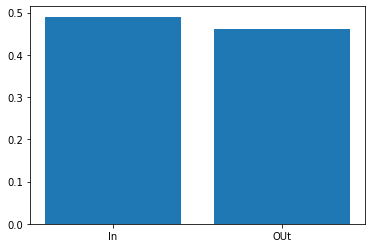

In [ ]:
from matplotlib import pyplot as plt
plt.bar(["In","OUt"],[In_accuracy, Out_accuracy])

#5.) Write an observation/conclusion about the graphs from Q4 and Q3

As we can see from the graphs in Question 3, the difference in accuracy between in-sample and out-of-sample is not significant, so we can say that there is no overfitting problem. It can be said that there is no overfitting problem. Since the accuracy is close to 0.5, we can say that the prediction is quite accurate.

# 6.) Create a parameter for number of lags in your input layer. Do a 3-fold CV to test three different time lags. i.e. Tested using 5,10,20 days of previous price data to forecast

In [ ]:
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from keras.wrappers.scikit_learn import KerasRegressor

# Define the Keras model
###Edit here to create your optimizer
def create_model(neurons = 5):
  model = Sequential()
  model.add(LSTM(neurons, input_shape = (5, 1)))
  model.add(Dense(1, activation='sigmoid'))
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  return(model)

# Wrap the Keras model in a scikit-learn compatible estimator
model = KerasRegressor(build_fn = create_model, verbose = 0)

# Define the hyperparameters to search over
param_grid = {'batch_size': [10, 20, 100],
         'epochs': [10, 100],
         'neurons':[5, 10, 20]}

# Perform the grid search over the hyperparameters
grid = GridSearchCV(estimator = model, param_grid = param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(x_train, y_train)

# Print the results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

<ipython-input-11-55a0445ebb2b>:15: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasRegressor(build_fn = create_model, verbose = 0)
/usr/local/lib/python3.8/dist-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best: -0.007222 using {'batch_size': 20, 'epochs': 10, 'neurons': 10}
